# Introduction

## Motivation & Problem statement

Up Until 2014 [3] blackouts occurred around the world have caused extreme economic and social ramifications. With the expansion of the scale powergrid, it is essential for the power grid to operate in a more stable manner that provides security and certainty [1],[2].

Given a dataset that contains 9568 data observations collected from a Combined Cycle Power Plant over 6 years (2006-2011),when the power plant was set to work with full load. The task is to build two cross-validated linear regression models that predict the energy production of a power plant.

## Check list to address the problem.

- Read-up more on how powerplants work to better understand the problem at hand. (SME)
- Get the data from a public repository to allow reproducibility.
- Discover the data and preform any necassary data transformations such as data cleaning.
- Create Exploratory data analysis viusalisations to gain insight.
- preform feature selection and if possible feature extraction. (in reference to the explanatory features)
- Normalize or standardize the features.
- Create two cross-validated linear regression models.
- Evaluate the regression models using the test set.
- Present conculsions.

## Data

- Explanatory/Independant
    
    - Temperature (T) in the range 1.81°C and 37.11°C,
    - Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
    - Relative Humidity (RH) in the range 25.56% to 100.16%
    - Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg

- Response/Dependant
    
    - Net hourly electrical energy output (EP) 420.26-495.76 MW

# Get the data.

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Reading from public github repo.
df = pd.read_csv("https://raw.githubusercontent.com/OMS1996/DAV-Data-Science/master/Data/M2_Data.csv")  

# Renaming the cols.
df.columns = ['temperature','exhaust_vacuum','ambient_pressure','relative_humidity','net_hourly_electrical energy']

In [3]:
df.head(3)

,temperature,exhaust_vacuum,ambient_pressure,relative_humidity,net_hourly_electrical energy
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56


In [4]:
df.info()
print("\nAre there any missing values in the data set ?: ",df.isnull().values.any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
temperature                     9568 non-null float64
exhaust_vacuum                  9568 non-null float64
ambient_pressure                9568 non-null float64
relative_humidity               9568 non-null float64
net_hourly_electrical energy    9568 non-null float64
dtypes: float64(5)
memory usage: 373.8 KB

Are there any missing values in the data set ?:  False


In [5]:
print(df.describe())

       temperature  exhaust_vacuum  ambient_pressure  relative_humidity  \
count  9568.000000     9568.000000       9568.000000        9568.000000   
mean     19.651231       54.305804       1013.259078          73.308978   
std       7.452473       12.707893          5.938784          14.600269   
min       1.810000       25.360000        992.890000          25.560000   
25%      13.510000       41.740000       1009.100000          63.327500   
50%      20.345000       52.080000       1012.940000          74.975000   
75%      25.720000       66.540000       1017.260000          84.830000   
max      37.110000       81.560000       1033.300000         100.160000   

       net_hourly_electrical energy  
count                   9568.000000  
mean                     454.365009  
std                       17.066995  
min                      420.260000  
25%                      439.750000  
50%                      451.550000  
75%                      468.430000  
max                 

# EDA.

Key points:

- Attributes seem to have different scales namely the ambient pressure for. [1 millibar equals to 0.075006156130264 cmHg ]


- Ambient pressure is normally distributed with approximately 1 outlier with the data not being very dispersed.

- relative humidity is heavily skewed to the left which could make it harder for linear regression to detect the pattern
    we should try to make it look a bit more normally distributed.

- net hourly electrical energy is very dispersed with a the highest standard deviation.

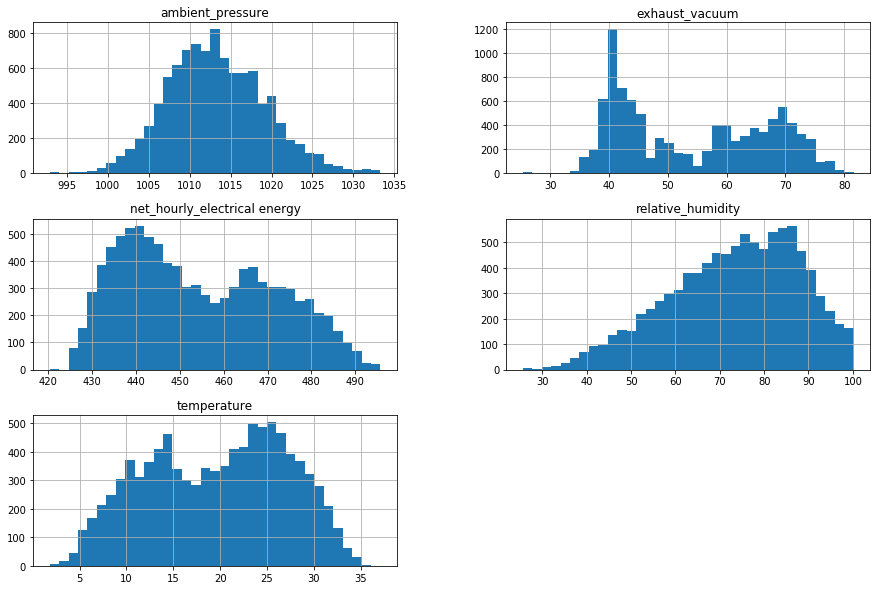

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=35, figsize=(15,10))
plt.show()

In [7]:
# We here have the ambient turned from milibar into cmhg
df['ambient_pressure'] = df['ambient_pressure'] * 0.075006156130264
# Keep a copy of this dataset.
df2 = df.copy()

In [8]:
df.head(3)

,temperature,exhaust_vacuum,ambient_pressure,relative_humidity,net_hourly_electrical energy
0,14.96,41.76,76.811554,73.17,463.26
1,25.18,62.96,76.509279,59.08,444.37
2,5.11,39.40,75.918231,92.14,488.56


In [9]:
corr_matrix2 = df.corr()
corr_matrix2['net_hourly_electrical energy'].sort_values(ascending = False)

net_hourly_electrical energy    1.000000
ambient_pressure                0.518429
relative_humidity               0.389794
exhaust_vacuum                 -0.869780
temperature                    -0.948128
Name: net_hourly_electrical energy, dtype: float64

In [10]:
corr_matrix2 = df.corr()
corr_matrix2

,temperature,exhaust_vacuum,ambient_pressure,relative_humidity,net_hourly_electrical energy
temperature,1.000000,0.844107,-0.507549,-0.542535,-0.948128
exhaust_vacuum,0.844107,1.000000,-0.413502,-0.312187,-0.869780
ambient_pressure,-0.507549,-0.413502,1.000000,0.099574,0.518429
relative_humidity,-0.542535,-0.312187,0.099574,1.000000,0.389794
net_hourly_electrical energy,-0.948128,-0.869780,0.518429,0.389794,1.000000


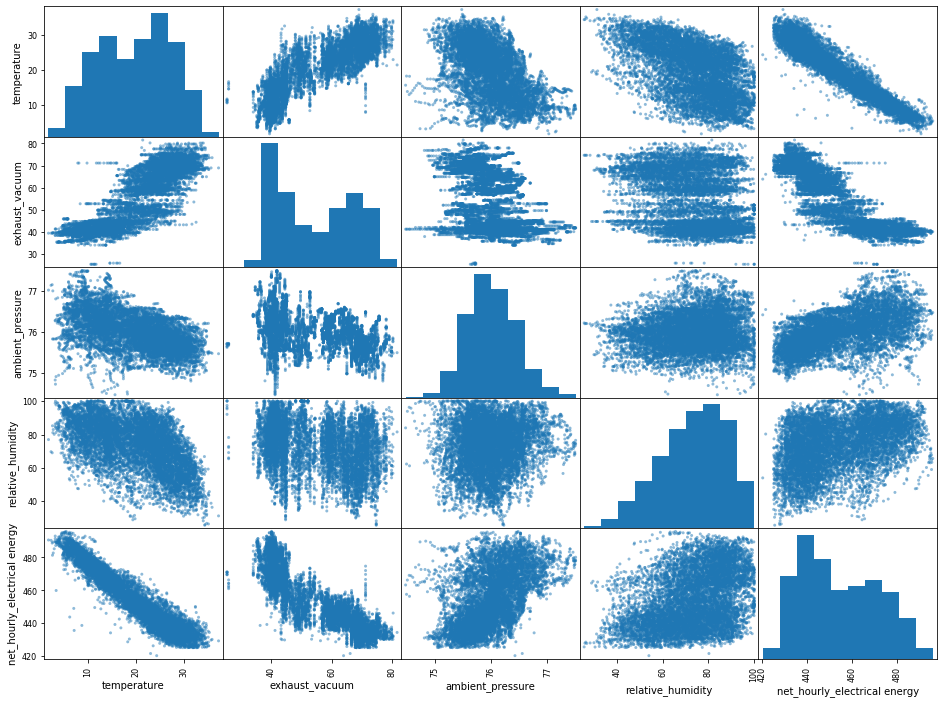

In [11]:
# from pandas.tools.plotting import scatter_matrix
from pandas.plotting import scatter_matrix

attributes = df.columns
scatter_matrix(df[attributes], figsize=(16, 12))
plt.show();

# Condenser System review
<img src="/Images/condenser.PNG"> [4].

# Feature Extraction

    After consulting a subject matter expert in electricity and power,i thought that it would be interesting to see what a new explanatory variable:

    (ambient_pressure - exhaust_vaccum) and dub it as energy,this would be more representative.

In [12]:
# Creating the new variable
df2['energy'] = df2['ambient_pressure'] - df2['exhaust_vacuum']

# Result of feature selection 

As you can clearly see, energy is a lot more correlated that the two variables on their own.

net_hourly_electrical energy    1.000000
energy                          0.874833
ambient_pressure                0.518429
relative_humidity               0.389794
exhaust_vacuum                 -0.869780
temperature                    -0.948128
Name: net_hourly_electrical energy, dtype: float64


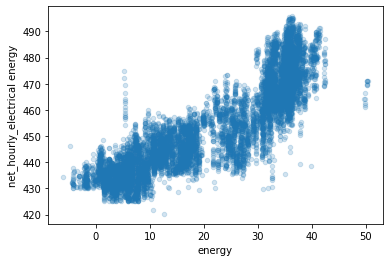

In [13]:
# Re-evaluating the correlation matrix.
corr_matrix2 = df2.corr()
print(corr_matrix2['net_hourly_electrical energy'].sort_values(ascending = False))

# Printing the relationship
df2.plot(kind="scatter", x="energy", y="net_hourly_electrical energy",alpha=0.2)
plt.show();

In [14]:
# rearrange
df2 = df2[['temperature','ambient_pressure','energy','relative_humidity','net_hourly_electrical energy']]
df2.head(1)

,temperature,ambient_pressure,energy,relative_humidity,net_hourly_electrical energy
0,14.96,76.811554,35.051554,73.17,463.26


In [15]:
corr_matrix2 = df2.corr()
corr_matrix2

,temperature,ambient_pressure,energy,relative_humidity,net_hourly_electrical energy
temperature,1.000000,-0.507549,-0.849163,-0.542535,-0.948128
ambient_pressure,-0.507549,1.000000,0.441928,0.099574,0.518429
energy,-0.849163,0.441928,1.000000,0.311014,0.874833
relative_humidity,-0.542535,0.099574,0.311014,1.000000,0.389794
net_hourly_electrical energy,-0.948128,0.518429,0.874833,0.389794,1.000000


# Model 1: Full model without energy column

In [16]:
# Loading the dataset
# ---------------------
X = df.iloc[:, :-1].values
y = df['net_hourly_electrical energy'].values

In [17]:
# Splitting the dataset into the Training set and Test set
# --------------------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Feature scaling Through standization
# -------------------------------------
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [19]:
# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor1 = LinearRegression()
regressor1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
# Cross-Validation
#-------------------------
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regressor1, X_train, y_train,scoring="neg_mean_squared_error", cv=10)
lin_reg_scores = np.sqrt(-scores)

In [21]:
def display_scores(scores):
    print("Scores:\n")
    print(scores)
    print()
    print("Mean:",scores.mean())
    print()
    print("Standard Deviation:",scores.std())
    
display_scores(lin_reg_scores)

Scores:

[4.75875318 4.52195625 4.76598322 4.68722621 4.43323295 4.37982178
 4.53566076 4.49053389 4.70580606 4.44500285]

Mean: 4.572397714190729

Standard Deviation: 0.1365519988903415


In [22]:
# testing set
# -------------------------------------
from sklearn.metrics import mean_squared_error
y_pred = regressor1.predict(X_test)
lin_mse = mean_squared_error(y_test, y_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

4.502633229532185

# Model 2: Model with energy replacing both exhaust_vacuum and ambient pressure.

In [23]:
# Loading the dataset
# ---------------------
X = df2.iloc[:, :-1].values # Explanatory
y = df2['net_hourly_electrical energy'].values # Response

In [24]:
# Splitting the dataset into the Training set and Test set
# --------------------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Feature scaling Through standization
# -------------------------------------
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [26]:
# Fitting Multiple Linear Regression to the Training set
# -------------------------------------
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
# Cross-validation
# -------------------------------------
from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor,X_train,y_train,scoring="neg_mean_squared_error", cv=10)
lin_reg_scores = np.sqrt(-scores)

In [28]:
def display_scores(scores):
    print("Scores:\n")
    print(scores)
    print()
    print("Mean:",scores.mean())
    print()
    print("Standard Deviation:",scores.std())
    
display_scores(lin_reg_scores)

Scores:

[4.75875318 4.52195625 4.76598322 4.68722621 4.43323295 4.37982178
 4.53566076 4.49053389 4.70580606 4.44500285]

Mean: 4.572397714190729

Standard Deviation: 0.13655199889034136


In [29]:
# testing set
# -------------------------------------
from sklearn.metrics import mean_squared_error
y_pred = regressor.predict(X_test)
lin_mse = mean_squared_error(y_test, y_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

4.502633229532186

# Conclusion

- Since both models are have practicaly the same results i would say the first model (which is the original full model) with no alterations because it is as computationally expensive.

- Exhaust vaccum variable was highly correlated with the temperature variable as it almost seems redundant so when the choice comes as which feature should we remove then it has to be Exhaust vaccum because temperature has a lot of information to offer.

- Temperature and relative humidity are a good predictors for the response variable, however temperature is better.

- The extra added variable 'energy' did not contribute to the model net_hourly_electrical energy as it is highly correlated with the temperature variable.



# Refrences

[1] Cˇepin M. Assessment of power system reliability: method and
applications. Springer; 2011.

[2] India ministry of power. Report of the enquiry committee on grid disturbance
in northern region on 30th July 2012 and in northern, eastern & north-eastern
region on 31st July 2012; 2012

[3] https://www.eia.gov/todayinenergy/detail.php?id=19271

[4] https://www.watco-group.co/surface-condenser-in-thermal-power-plant/